# Lab 6: It's a Bird! It's a Plane! It's... a Convolutional Neural Network

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
November 27, 2023

For this lab, we will be using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which we also used in Lab 2. 

In [1]:
# Import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.1.2
Numpy version: 1.24.3
Tensorflow version: 2.13.0


In [2]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
N_CLASSES = 10

tf.random.set_seed(2)
np.random.seed(0)
tf.config.list_physical_devices('GPU')

# Load the data
(X, y), _ = tf.keras.datasets.cifar10.load_data()

# Convert to grayscale
# X = tf.image.rgb_to_grayscale(X).numpy()

# Normalize the data
X = X / 255.0

print('X_train shape:', X.shape)
print('y_train shape:', y.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


There are 10 different classes in the dataset that each image belongs to:

| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Evaluation Metric

Our evaluation metric of choice for this lab will be classification accuracy. The CIFAR-10 dataset is intended to serve as a benchmark for machine learning and computer vision algorithms. It does not have a specific real-world application, other than testing models. Its business case is limited to training and evaluating models. Unlike a healthcare application where we might want to use FBeta score since want to strongly penalize false negatives in our evaluation, we are not interested in assigning special weightings to precision or recall; we only want to see how well our algorithm can classify the test data. With that in mind, accuracy is the correct metric for us to evaluate our convolutional neural networks on. We will be able to compare the performance of our models by seeing how well they deal with CIFAR-10's different classes.

### Data Division

First, the CIFAR-10 dataset contains 50,000 total images in its train batch, which we imported earlier. Of those 50,000 images, we will only use 5000 images. Using too many images will greatly increase our training runtime, and we believe we can get solid classification accuracy by using a subset of the data. We can always increase our sample size later.

Of those 5000 samples, we are going to use a train / test split of 80% / 20%. At 5000 instances, our dataset is sized well enough where we feel one train / test split will be sufficient, without also needing to perform shuffle splits or k-fold cross validation. Additionally, the CIFAR-10 dataset has no class imbalance; out of the 50,000 total images in the original dataset, 5000 instances of each class exist, so each class takes up exactly 10% of the dataset. In order to mirror this class balance, we will perform stratified selection when we split the data.

Although we don't have a true business case for CIFAR-10, this split is still a realistic method to use because it is how other similarly sized datasets are often preprocessed. Especially if we had a large class imbalance, we would still want to use stratified selection. The 80% / 20% is a standard, widely accepted practice for machine learning datasets of this size.

In [4]:
# Only use 5000 samples
X = X[:5000]
y = y[:5000]

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4000, 32, 32, 3)
y_train shape: (4000, 1)
X_test shape: (1000, 32, 32, 3)
y_test shape: (1000, 1)


C:\Users\Owner\AppData\Local\Temp\ipykernel_15620\714973407.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_unique, y=test_count, palette='rocket', ax=ax[0])
C:\Users\Owner\AppData\Local\Temp\ipykernel_15620\714973407.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_unique, y=train_count, palette='rocket', ax=ax[1])


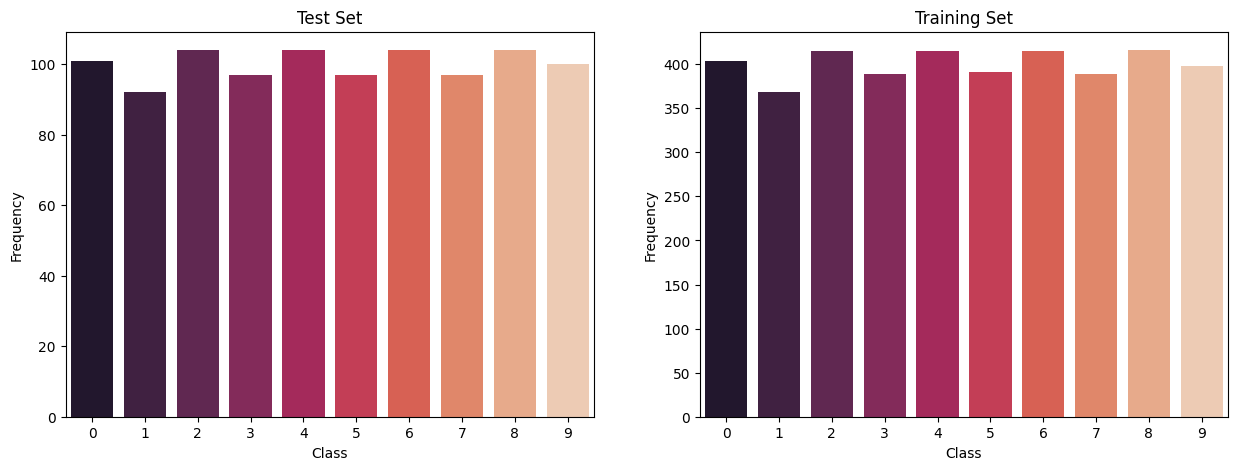

In [6]:
# graph the distribution of the training and test sets
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
test_unique, test_count = np.unique(y_test, return_counts=True)
train_unique, train_count = np.unique(y_train, return_counts=True)
sns.barplot(x=test_unique, y=test_count, palette='rocket', ax=ax[0])
ax[0].set_title('Test Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
sns.barplot(x=train_unique, y=train_count, palette='rocket', ax=ax[1])
ax[1].set_title('Training Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
plt.show()

We can see that we pretty closely mirror the class balance of the original dataset, although it's not perfectly 10% for each.

In [7]:
tf.config.list_physical_devices('GPU')

[]

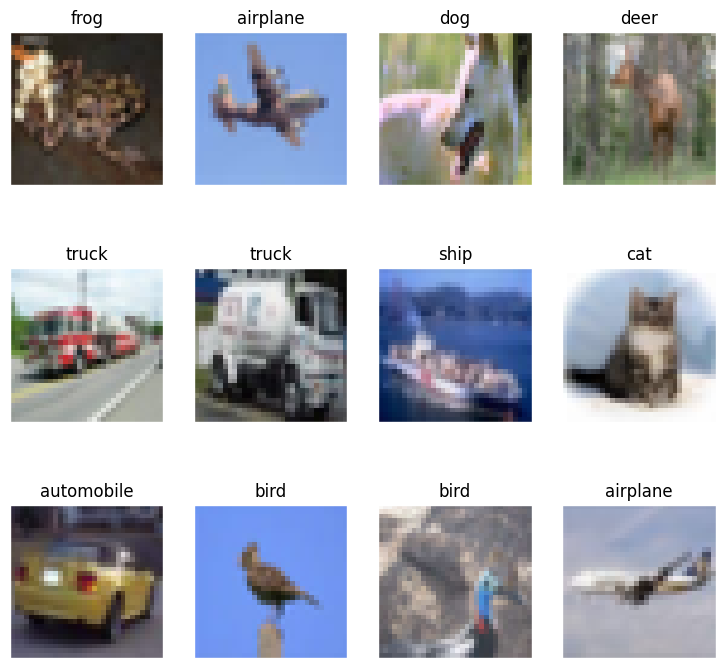

In [8]:
# Plot images
plt.style.use('ggplot')

def plot_gallery(images, titles, h, w, channels=3, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, channels)), cmap=plt.cm.gray)
        plt.title(labels[int(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, IMG_HEIGHT, IMG_WIDTH)

In [9]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

### CNN 1

Our first CNN is a straightforward architecture. It is comprised of 7 total layers: a RandomFlip, RandomRotation, Convolution, Activation, MaxPool, Flatten, and a Dense layer, in that order.

The first two layesr are data augmentation layers; first, a random horizontal flip layer and a random rotation layer. We place these first in the network so that our input data is augmented before moving through the rest of the network. We want to use data augmentation for a few key reasons. 

First, augmentation increases our models' robustness to variations. Augmentation introduces variations in the training data. By introducing random rotations and flips, the model will become more resilient to slight differences in the images. This is useful because we might have images of objects in the same class, like a bird, that are photographed from different angles. If our model knows how to detect features of birds regardless of how the birds are framed in the picture, it will be able to much more consistently classify them as birds. We're not going too crazy with the augmentation layers; we believe that only two layers for flipping and rotating would accurately mirror a real-world, generalized scenario where someone could be holding a camera from many different angles. 

Additionally, augmentation will help to prevent overfitting. Augmentation techniques act as a form of regularization by artificially increasing the diversity of the training dataset. By adding the augmentation layers, we can prevent the model from memorizing specific details of the training images and instead encourage learning of more generalized features. This can reduce overfitting and improve the model's ability to generalize to new, unseen images.

In [10]:
# one hot encode outputs
y_train_ohe = keras.utils.to_categorical(y_train, N_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, N_CLASSES)

# Define the model
cnn = Sequential(name='cnn')

# Add data augmentation layers
cnn.add(RandomFlip('horizontal'))
cnn.add(RandomRotation(0.2))

# Add convolutional layers
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn.add(Flatten())
cnn.add(Dense(N_CLASSES, activation='softmax'))

# Build the model
cnn.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn.summary())

# Plot the model
plot_model(
    cnn, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 32, 32, 3)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8192)              0       

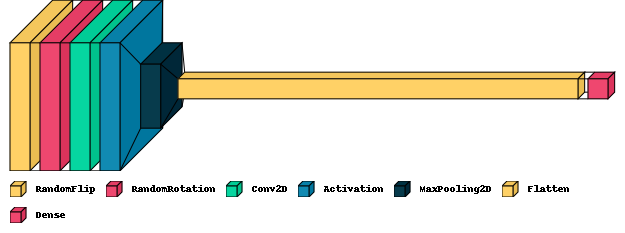

In [11]:
import visualkeras
visualkeras.layered_view(cnn, legend=True)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn.fit(X_train, y_train_ohe, epochs=100, batch_size=128, shuffle=True, 
                      validation_data=(X_test, y_test_ohe), verbose=1, )
                    #   callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100
32/32 [==============================] - 2s 30ms/step - loss: 2.1359 - accuracy: 0.2275 - val_loss: 1.9755 - val_accuracy: 0.2890
Epoch 2/100
32/32 [==============================] - 1s 25ms/step - loss: 1.9017 - accuracy: 0.3160 - val_loss: 1.9265 - val_accuracy: 0.3280
Epoch 3/100
32/32 [==============================] - 1s 27ms/step - loss: 1.8309 - accuracy: 0.3505 - val_loss: 1.8433 - val_accuracy: 0.3660
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 1.7847 - accuracy: 0.3738 - val_loss: 1.8414 - val_accuracy: 0.3440
Epoch 5/100
32/32 [==============================] - 1s 31ms/step - loss: 1.7543 - accuracy: 0.3805 - val_loss: 1.8473 - val_accuracy: 0.3570
Epoch 6/100
32/32 [==============================] - 1s 28ms/step - loss: 1.7160 - accuracy: 0.3913 - val_loss: 1.7956 - val_accuracy: 0.3580
Epoch 7/100
32/32 [==============================] - 1s 28ms/step - loss: 1.6959 - accuracy: 0.4045 - val_loss: 1.7446 - val_accuracy: 0.3800
Epoch 

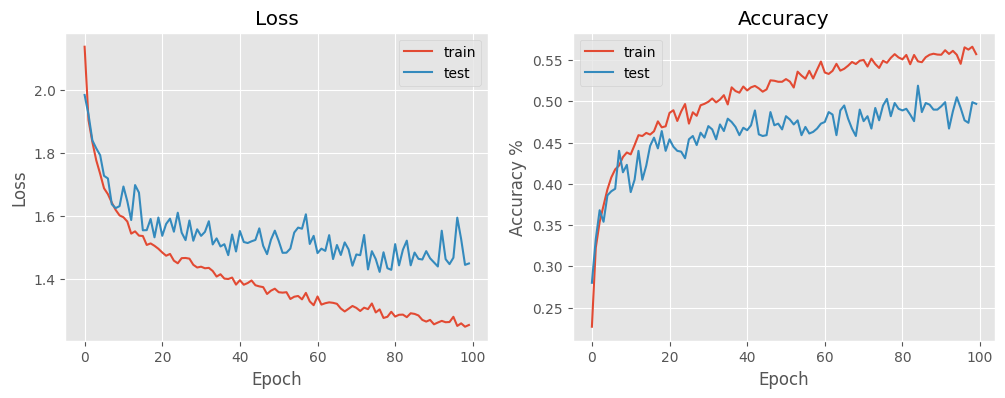

In [14]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

### TODO: Ensure accuracy for submission.

From our graph of loss vs. epochs, we can see that our training converges. Our best accuracy with CNN1 so far is around 56% for training and 50% for validation. This is a good starting point for a more simple architecture.

### CNN 2

For our next CNN, we decided to make the architecture much more complex, with 25 layers in total. We have a total of 6 CNNs with batch normalization after each cnn layer. Then, after every two CNNs, we max pooled and performed dropout. In this model, we also use two dense layers at the end instead of just one. We still use the same 2 augmentation layers at the start, the RandomFlip and the RandomRotation.

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_1 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128    

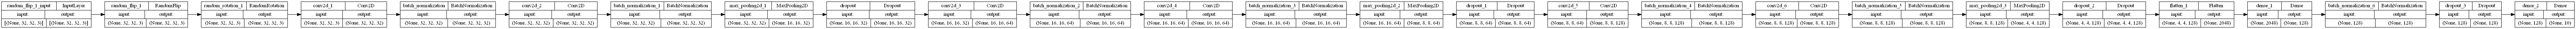

In [15]:
cnn2 = Sequential(name='cnn2')

# Add data augmentation layers
cnn2.add(RandomFlip('horizontal'))
cnn2.add(RandomRotation(0.2))

cnn2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.3))

cnn2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.5))

cnn2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.5))

cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Dropout(0.5))
cnn2.add(Dense(N_CLASSES, activation='softmax'))

cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn2.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn2.summary())

# Plot the model
plot_model(
    cnn2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

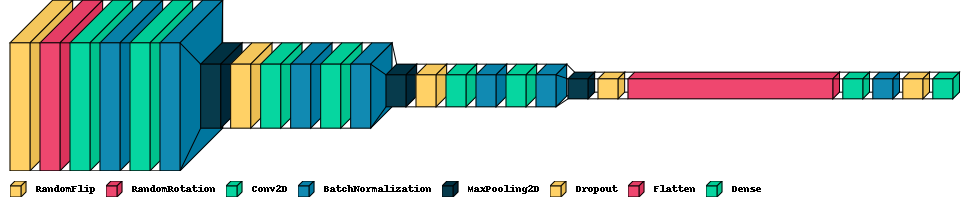

In [16]:
visualkeras.layered_view(cnn2, legend=True)

In [17]:
cnn2_history = cnn2.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True, 
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=7)])

Epoch 1/100
63/63 [==============================] - 20s 240ms/step - loss: 2.8620 - accuracy: 0.1960 - val_loss: 2.9779 - val_accuracy: 0.1040
Epoch 2/100
63/63 [==============================] - 15s 236ms/step - loss: 2.2536 - accuracy: 0.2627 - val_loss: 3.6530 - val_accuracy: 0.1060
Epoch 3/100
63/63 [==============================] - 16s 250ms/step - loss: 2.0766 - accuracy: 0.2803 - val_loss: 4.0249 - val_accuracy: 0.1060
Epoch 4/100
63/63 [==============================] - 14s 228ms/step - loss: 1.9920 - accuracy: 0.3220 - val_loss: 3.5384 - val_accuracy: 0.1340
Epoch 5/100
63/63 [==============================] - 16s 247ms/step - loss: 1.9249 - accuracy: 0.3187 - val_loss: 2.8168 - val_accuracy: 0.1680
Epoch 6/100
63/63 [==============================] - 15s 236ms/step - loss: 1.8302 - accuracy: 0.3543 - val_loss: 2.5934 - val_accuracy: 0.1830
Epoch 7/100
63/63 [==============================] - 17s 265ms/step - loss: 1.7701 - accuracy: 0.3697 - val_loss: 2.1223 - val_accuracy:

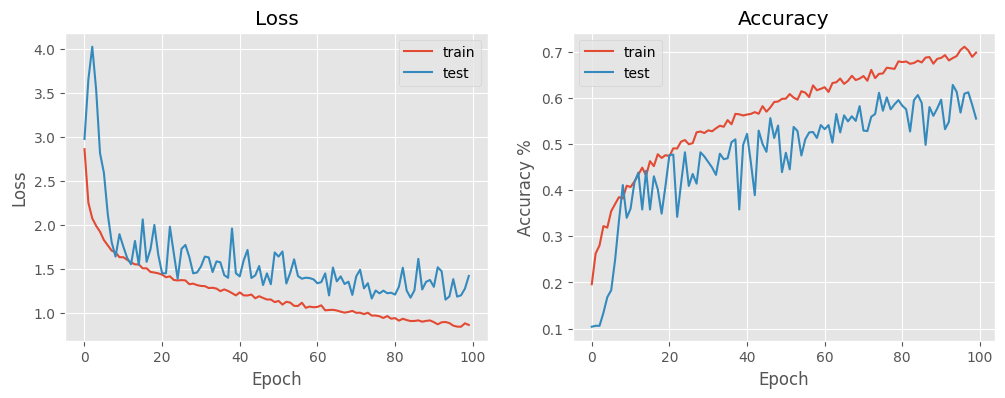

In [20]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn2_history.history['loss'], label='train')
plt.plot(cnn2_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn2_history.history['accuracy'], label='train')
plt.plot(cnn2_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

### TODO: Confirm accuracy for submission.

We can see that our training is converging from the loss vs. epochs graph. Our training accuracy steadily rises and peaks at around 71%, while our validation accuracy is a more spiky and peaks at around 62%. Although this model takes much longer to fit, it is a considerable improvement on our accuracy from CNN 1's architecture.

Let's compare the performance of our two different architectures:

In [18]:
# Helper function to plot two confusion matrices for CNN
from sklearn import metrics as mt
import seaborn as sns
def confusion_matrix_compare(model, model2, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15, 5))
    if model is not None:
        yhat = np.argmax(model.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 1)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model.name}: {acc:.3f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    
    if model2 is not None:
        yhat = np.argmax(model2.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 2)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model2.name}: {acc:.3f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

32/32 [==============================] - 1s 21ms/step


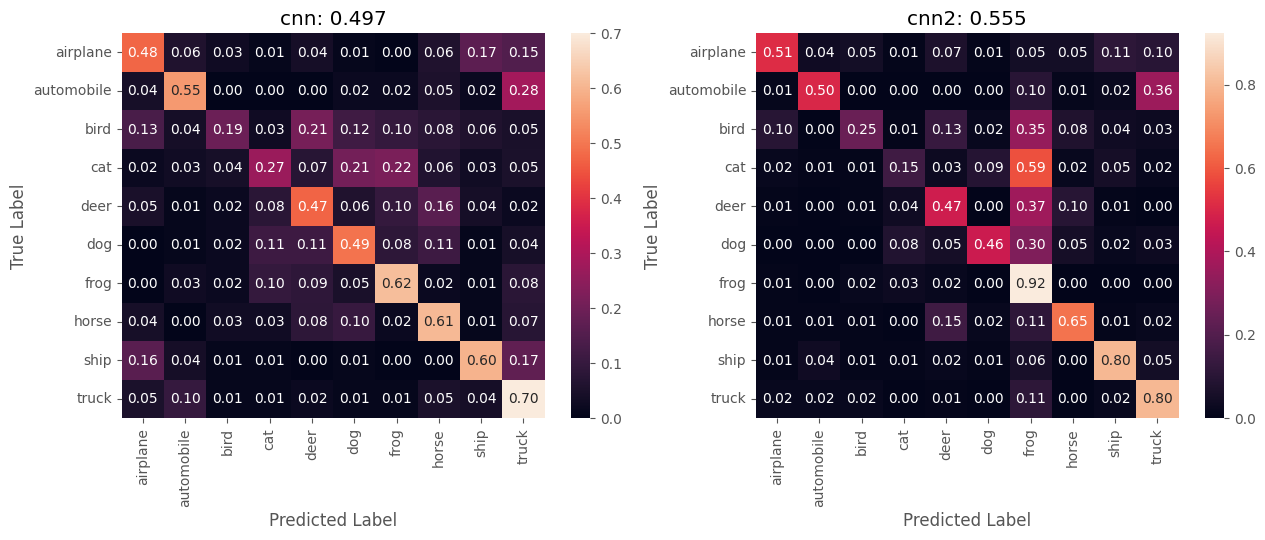

In [24]:
confusion_matrix_compare(cnn, cnn2, X_test, y_test, labels=labels)

### TODO: Ensure accuracy for submission.

Overall, cnn2's accuracy_score is higher than cnn1. We can say that cnn2 performs better than cnn1 for now, and we can see that for many categories, cnn2 is less confused than cnn1. However, the confusion matrices expose some interesting differences. For example, when classifying frogs, cnn2 is very accurate, with a 92% true positive rate, but it also has considerably more false positives in the frog column. It has a 59% false positive rate in the frog-cat cell, meaning 59% of instances that are truly frogs were incorrectly classified as cats. It also has higher false positive rates for deers, birds, and dogs. This is interesting - although our true positive rate on cnn2 is generally higher, we seem to have more false positives. So although cnn2 is more accurate overall, it does struggle from some false positive issues. Maybe the false positive issues are because the animal photos might be placed in similar environments outdoors, with greenery or skies visible - this could lead the algorithm to be confused on animal classification. There's not much confusion between other categories at all in cnn2, except between trucks and automobiles, which makes sense given the similarity of those categories as well.

Although we're pretty sure these models are different, let's make sure by performing a statistical test, in this case a paired t-test:

In [36]:
# Helper function to perform a paired t-test statistical comparison between the evaluation metric of two models

from scipy import stats

def paired_t_test(model1_history, model2_history):
    
    # Perform a paired t-test
    t_statistic, p_value = stats.ttest_rel(model1_history.history['accuracy'], model2_history.history['accuracy'])
    
    # Print the results
    print(f"Paired t-test results:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Check for statistical significance with alpha = 0.05, denoting a 95% confidence level
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between model 1 and model 2.")
    else:
        print("Fail to reject the null hypothesis: No significant difference found between model 1 and model 2.")


In [37]:
paired_t_test(cnn_history, cnn2_history)

Paired t-test results:
T-statistic: -9.990827917766914
P-value: 1.1455536637923783e-16
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


Indeed, by comparing each model's history, we see that there is a statistical difference between cnn1 and cnn2.

### CNN3: CNN 1 with Changed Parameters

For our next model, we changed some of the parameters around from our first architecture, cnn1. 
In this network, we increased the number of filters from 32 to 128. We also decreased the random roation to 0.1. The batch size was also lowered from 128 to 64.

Model: "cnn3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_2 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0      

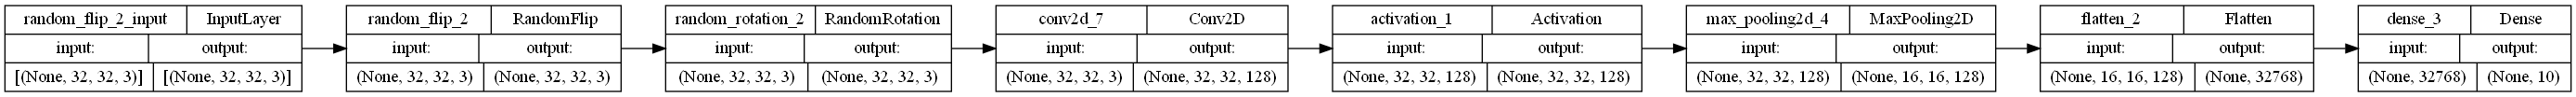

In [38]:
# Define the model
cnn3 = Sequential(name='cnn3')
# Add data augmentation layers
cnn3.add(RandomFlip('horizontal'))
cnn3.add(RandomRotation(0.1))

# Add convolutional layers
cnn3.add(Conv2D(128, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn3.add(Flatten())
cnn3.add(Dense(N_CLASSES, activation='softmax'))

# Build the model
cnn3.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
cnn3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(cnn3.summary())

# Plot the model
plot_model(
    cnn3, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

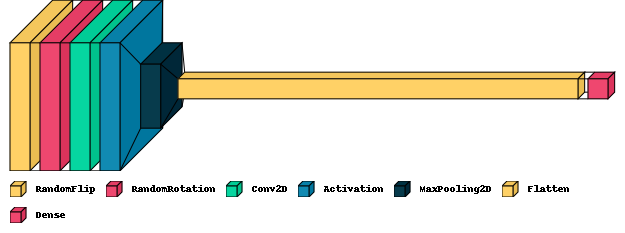

In [39]:
visualkeras.layered_view(cnn3, legend=True)

In [46]:
cnn3_history = cnn3.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6918 - accuracy: 0.7617 - val_loss: 1.5398 - val_accuracy: 0.5390
Epoch 2/100
63/63 [==============================] - 4s 59ms/step - loss: 0.7002 - accuracy: 0.7565 - val_loss: 1.5390 - val_accuracy: 0.5460
Epoch 3/100
63/63 [==============================] - 4s 59ms/step - loss: 0.6925 - accuracy: 0.7552 - val_loss: 1.5504 - val_accuracy: 0.5510
Epoch 4/100
63/63 [==============================] - 4s 61ms/step - loss: 0.7067 - accuracy: 0.7538 - val_loss: 1.6517 - val_accuracy: 0.5270
Epoch 5/100
63/63 [==============================] - 4s 63ms/step - loss: 0.6749 - accuracy: 0.7750 - val_loss: 1.6401 - val_accuracy: 0.5430
Epoch 6/100
63/63 [==============================] - 4s 65ms/step - loss: 0.6698 - accuracy: 0.7720 - val_loss: 1.5737 - val_accuracy: 0.5460
Epoch 7/100
63/63 [==============================] - 4s 67ms/step - loss: 0.6778 - accuracy: 0.7625 - val_loss: 1.6380 - val_accuracy: 0.5360
Epoch 

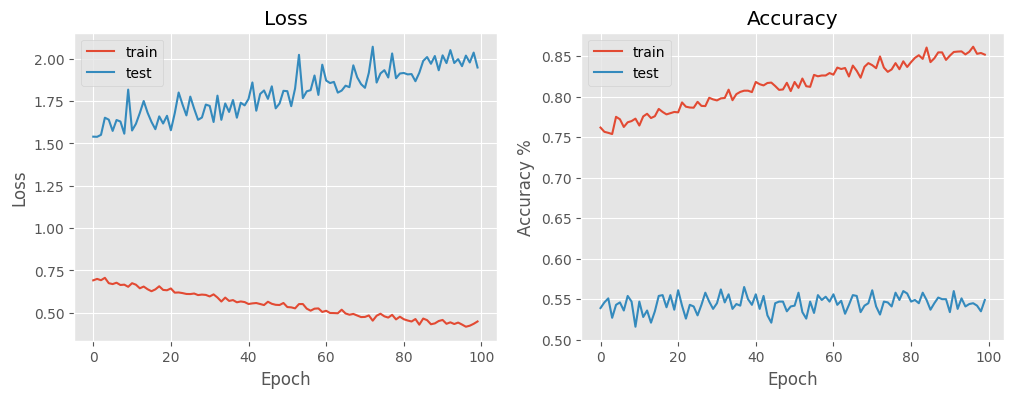

In [47]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn3_history.history['loss'], label='train')
plt.plot(cnn3_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn3_history.history['accuracy'], label='train')
plt.plot(cnn3_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

Again, we can see that the training converges based on our loss vs. epochs graph. Oddly, our loss stays very high on the validation. We are unsure why this is. For training accuracy, we start off strong and keep getting better, at over 85% after 100 epochs. However, our training accuracy does not really improve, instead hovering between 50-55% the whole time. This model is behaving a bit strangely. Let's compare it to what it's based on, model 1:

32/32 [==============================] - 0s 10ms/step


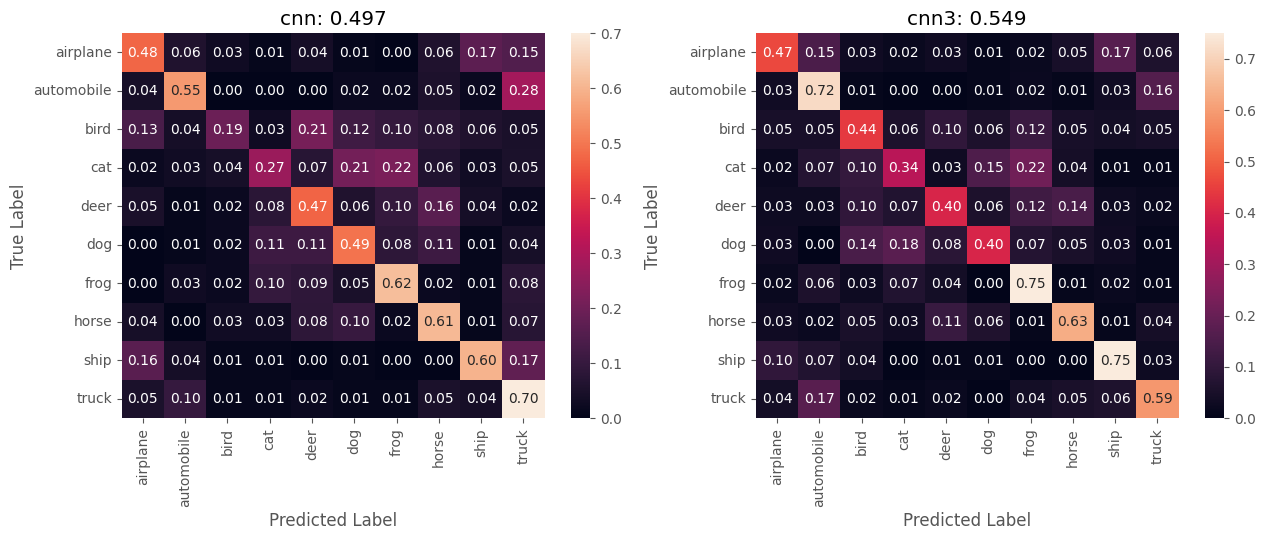

In [48]:
confusion_matrix_compare(cnn, cnn3, X_test, y_test, labels=labels)

### TODO: Confirm accuracy before submission.

cnn3 does have a higher accuracy_score than cnn1, and it is indeed less confused on certain classes than cnn1. 
cnn3 has a higher true positive rate for 6/10 of the categories, but for airplanes, deers, dogs, and trucks, cnn1 classifies more accurately. cnn1 has more confusion between methods of transportation like ships, trucks, airplanes, and automobiles. Again, there is some confusion with other categories when classifying frogs, but other than that, cnn3 is mostly performing better than its predecessor.

In [50]:
paired_t_test(cnn3_history, cnn_history)

Paired t-test results:
T-statistic: 89.42468274189635
P-value: 1.7013637278048688e-96
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


Again, we reject the null hypotheses. Our changing of the parameters between cnn1 and cnn3 did lead to a statistical difference (with 95% confidence) in how the models performed. This shows how despite the same overall architecture, changing the parameters can significantly alter how a model performs.

## CNN4: CNN2 with Changed Parameters
In this network we increased the size of the filter for the first two cnn's from 3x3 to 5x5. We also increased the number of neurons in the dense layer from 128 to 256.

In [20]:
cnn4 = Sequential(name='cnn4')
# Add data augmentation layers
cnn4.add(RandomFlip('horizontal'))
cnn4.add(RandomRotation(0.2))

cnn4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.3))

cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Flatten())
cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(N_CLASSES, activation='softmax'))

cnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn4.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn4.summary())

# Plot the model
plot_model(
    cnn4, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model: "cnn4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_1 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128    

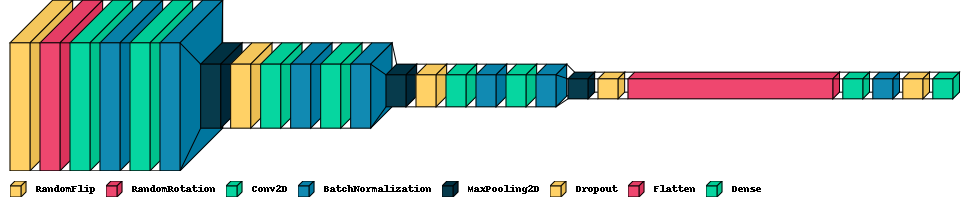

In [21]:
visualkeras.layered_view(cnn4, legend=True)

In [22]:
cnn4_history = cnn4.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
63/63 [==============================] - 15s 197ms/step - loss: 2.8262 - accuracy: 0.1992 - val_loss: 2.9244 - val_accuracy: 0.1040
Epoch 2/100
43/63 [===================>..........] - ETA: 3s - loss: 2.3224 - accuracy: 0.2700

KeyboardInterrupt: 

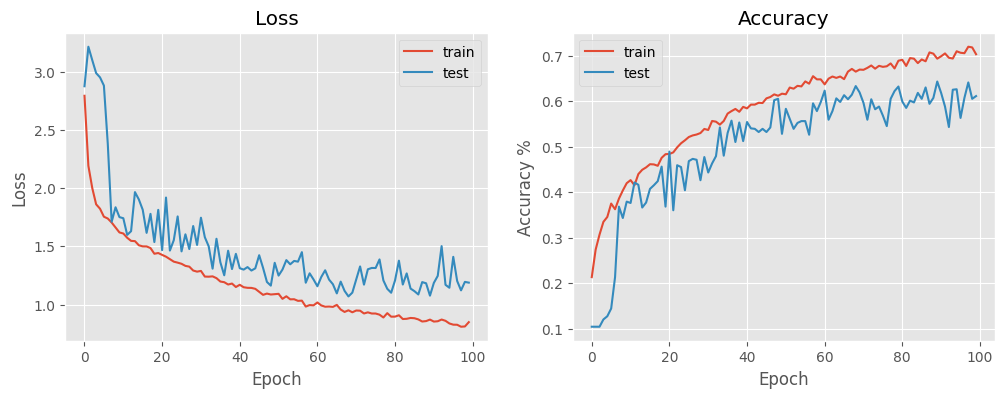

In [63]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn4_history.history['loss'], label='train')
plt.plot(cnn4_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn4_history.history['accuracy'], label='train')
plt.plot(cnn4_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

In [19]:
# TODO: Confirm that training converges.

32/32 [==============================] - 1s 19ms/step


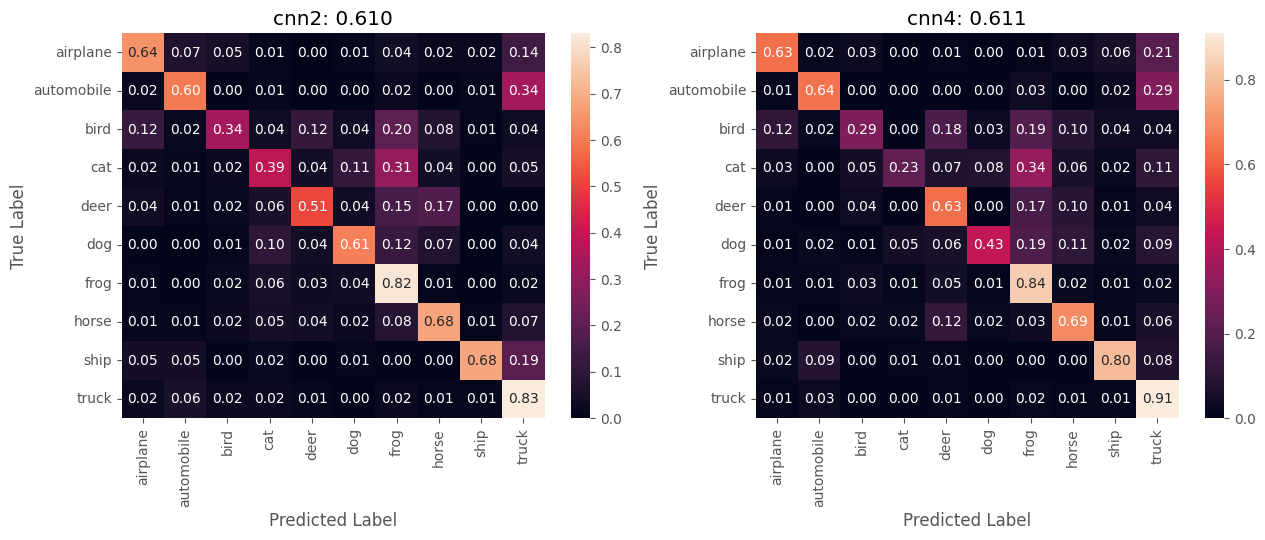

In [64]:
confusion_matrix_compare(cnn2, cnn4, X_test, y_test, labels=labels)

### TODO: Comparison of accuracy and confusion matrices
### TODO: Statistical test between CNN and CNN2
### TODO: Conclude which network is the best, then transition to MLP comparison

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 3072)              0         
                                                                 
 dense_32 (Dense)            (None, 128)               393344    
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dense_34 (Dense)            (None, 10)                1290      
                                                                 
Total params: 411146 (1.57 MB)
Trainable params: 411146 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


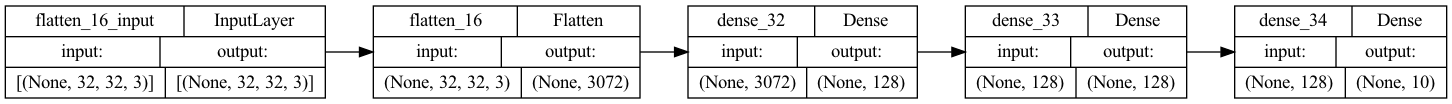

In [100]:
# baseline MLP model

mlp = Sequential(name='mlp')
mlp.add(Flatten())
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(N_CLASSES, activation='softmax'))

mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(mlp.summary())

plot_model(
    mlp, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [101]:
mlp_history = mlp.fit(X_train, y_train_ohe, epochs=50, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1)
#TODO: change to 100 epochs

Epoch 1/50
63/63 [==============================] - 8s 90ms/step - loss: 3.3915 - accuracy: 0.1308 - val_loss: 2.3057 - val_accuracy: 0.1300
Epoch 2/50
63/63 [==============================] - 4s 64ms/step - loss: 2.2090 - accuracy: 0.2015 - val_loss: 2.1945 - val_accuracy: 0.2260
Epoch 3/50
63/63 [==============================] - 4s 67ms/step - loss: 2.1980 - accuracy: 0.2202 - val_loss: 2.2882 - val_accuracy: 0.2100
Epoch 4/50
63/63 [==============================] - 4s 66ms/step - loss: 2.3248 - accuracy: 0.2077 - val_loss: 2.1745 - val_accuracy: 0.2550
Epoch 5/50
63/63 [==============================] - 4s 64ms/step - loss: 2.1704 - accuracy: 0.2485 - val_loss: 2.5708 - val_accuracy: 0.2240
Epoch 6/50
63/63 [==============================] - 4s 63ms/step - loss: 2.2571 - accuracy: 0.2498 - val_loss: 2.2931 - val_accuracy: 0.2240
Epoch 7/50
63/63 [==============================] - 4s 62ms/step - loss: 2.0447 - accuracy: 0.2825 - val_loss: 2.3050 - val_accuracy: 0.2420
Epoch 8/50
63

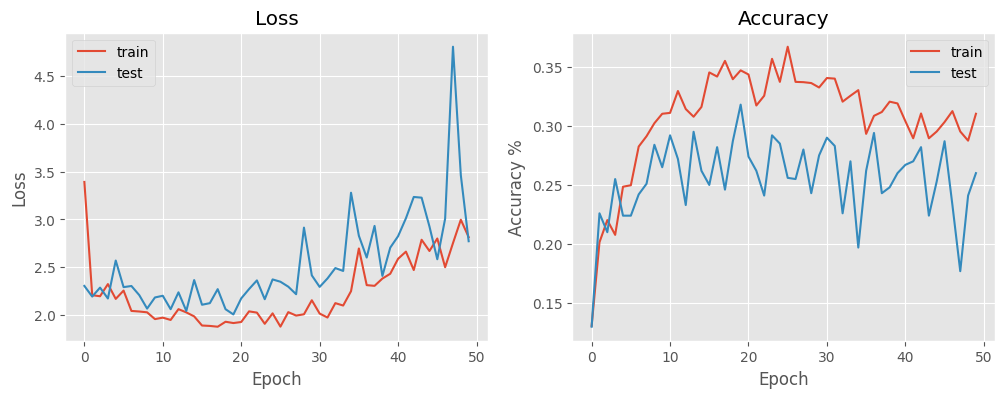

In [102]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['accuracy'], label='train')
plt.plot(mlp_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

32/32 [==============================] - 0s 6ms/step


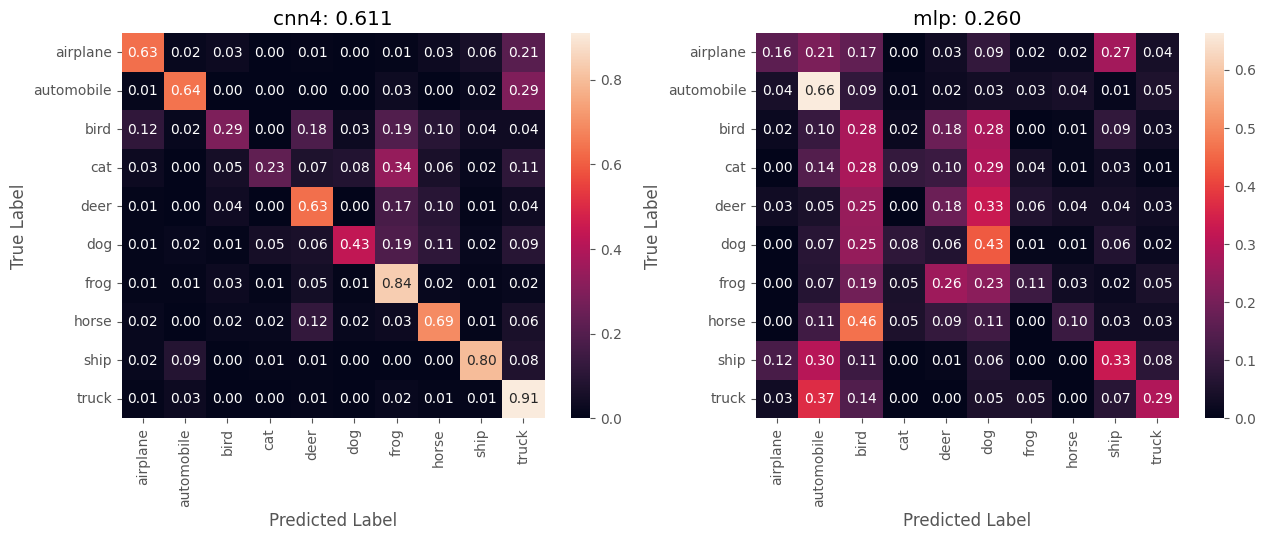

In [103]:
confusion_matrix_compare(cnn4, mlp, X_test, y_test, labels=labels)

### TODO: Comparison of accuracy and confusion matrices


32/32 [==============================] - 0s 4ms/step


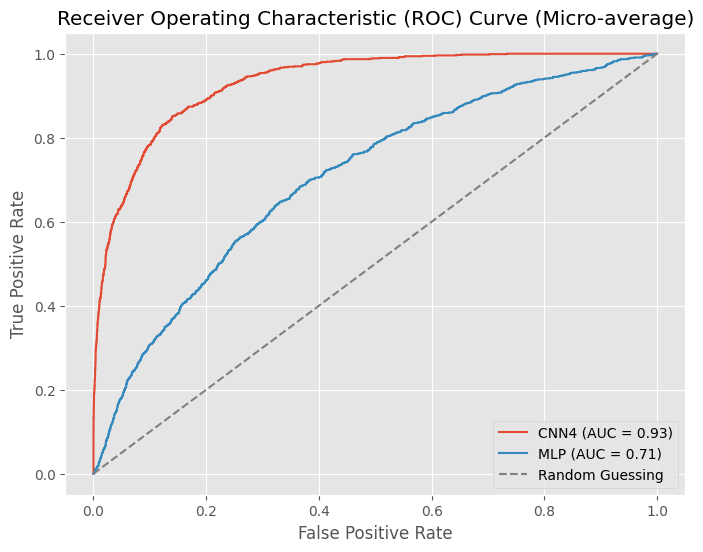

In [104]:
# ### Micro-Average ROC curve and AUC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_curve, auc

yhat_cnn4 = cnn4.predict(X_test)
yhat_mlp = mlp.predict(X_test)

y_true = y_test.ravel()

y_test_bin = label_binarize(y_true, classes=np.arange(N_CLASSES))  

cnn4_fpr = dict()
cnn4_tpr = dict()
cnn4_roc_auc = dict()

mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()

for i in range(N_CLASSES):
    cnn4_fpr[i], cnn4_tpr[i], _ = roc_curve(y_test_bin[:, i], yhat_cnn4[:, i])
    cnn4_roc_auc[i] = auc(cnn4_fpr[i], cnn4_tpr[i])

    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(y_test_bin[:, i], yhat_mlp[:, i])
    mlp_roc_auc[i] = auc(mlp_fpr[i], mlp_tpr[i])

# Compute micro-average ROC curve and ROC area
cnn4_fpr['micro'], cnn4_tpr['micro'], _ = roc_curve(y_test_bin.ravel(), yhat_cnn4.ravel())
cnn4_roc_auc['micro'] = auc(cnn4_fpr['micro'], cnn4_tpr['micro'])

mlp_fpr['micro'], mlp_tpr['micro'], _ = roc_curve(y_test_bin.ravel(), yhat_mlp.ravel())
mlp_roc_auc['micro'] = auc(mlp_fpr['micro'], mlp_tpr['micro'])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(cnn4_fpr['micro'], cnn4_tpr['micro'], label=f'CNN4 (AUC = {cnn4_roc_auc["micro"]:.2f})')
plt.plot(mlp_fpr['micro'], mlp_tpr['micro'], label=f'MLP (AUC = {mlp_roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Micro-average)')
plt.legend()
plt.grid(True)
plt.show()

### TODO: Statistical test between best CNN and MLP

### Exceptional Work: Transfer Learning

In [ ]:
cnn4 = Sequential(name='cnn4')
# Add data augmentation layers
cnn4.add(RandomFlip('horizontal'))
cnn4.add(RandomRotation(0.2))

cnn4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.3))

cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Flatten())
cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(N_CLASSES, activation='softmax'))

cnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn4.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn4.summary())

# Plot the model
plot_model(
    cnn4, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [13]:
cnn4_history = cnn4.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1,)

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 classes in CIFAR-10

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(model.summary())

58889256/58889256 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None


In [15]:
model_history = model.fit(X_train, y_train_ohe, epochs=50, batch_size=32, validation_data=(X_test, y_test_ohe))

Epoch 1/50
125/125 [==============================] - 8s 61ms/step - loss: 1.7414 - accuracy: 0.3885 - val_loss: 1.5356 - val_accuracy: 0.4470
Epoch 2/50
125/125 [==============================] - 8s 63ms/step - loss: 1.3913 - accuracy: 0.5163 - val_loss: 1.4482 - val_accuracy: 0.4850
Epoch 3/50
125/125 [==============================] - 8s 60ms/step - loss: 1.2687 - accuracy: 0.5677 - val_loss: 1.3933 - val_accuracy: 0.5010
Epoch 4/50
125/125 [==============================] - 8s 62ms/step - loss: 1.1858 - accuracy: 0.5855 - val_loss: 1.4193 - val_accuracy: 0.5080
Epoch 5/50
125/125 [==============================] - 8s 60ms/step - loss: 1.1099 - accuracy: 0.6165 - val_loss: 1.3786 - val_accuracy: 0.5160
Epoch 6/50
125/125 [==============================] - 8s 62ms/step - loss: 1.0569 - accuracy: 0.6405 - val_loss: 1.3650 - val_accuracy: 0.5170
Epoch 7/50
125/125 [==============================] - 8s 61ms/step - loss: 1.0132 - accuracy: 0.6553 - val_loss: 1.3594 - val_accuracy: 0.5300

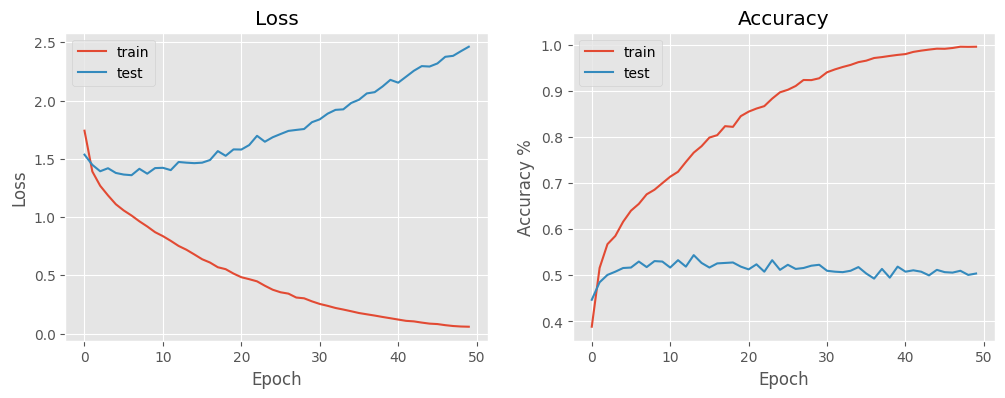

In [16]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='train')
plt.plot(model_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

32/32 [==============================] - 2s 62ms/step


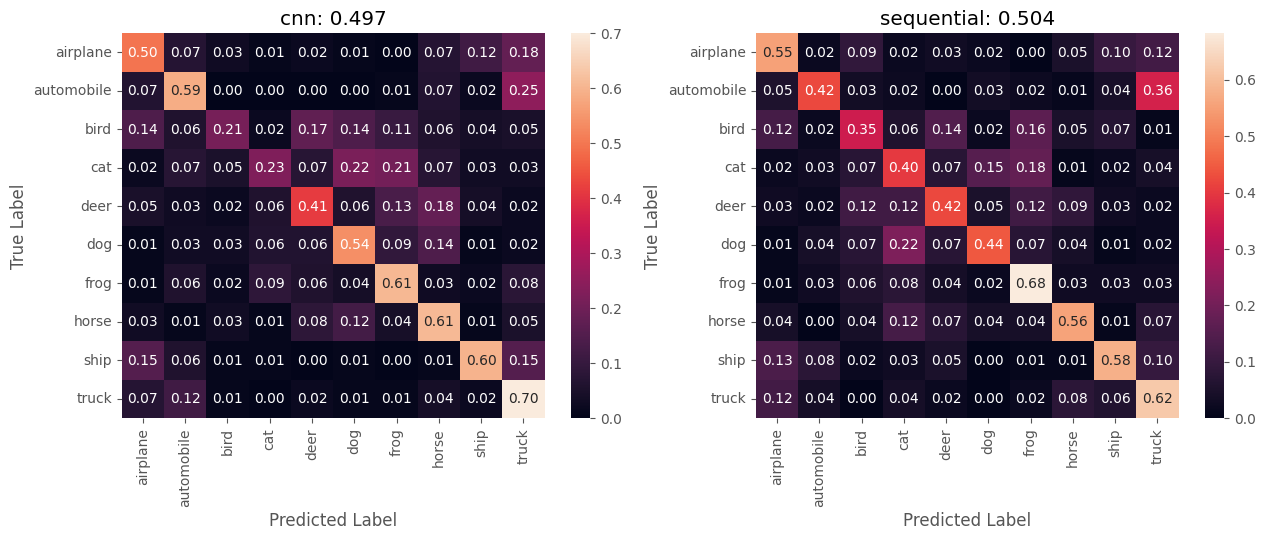

In [23]:
confusion_matrix_compare(cnn, model, X_test, y_test, labels=labels)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")